# Using Qurro with Arbitrary Compositional Data

Although Qurro was initially designed for use with microbiome sequencing data, it can totally be used on any sort of compositional data. The main challenge is just getting your data formatted properly.

We're going to demonstrate this by creating a Qurro visualization from "color composition data for 22 abstract paintings." These data were taken from Table 1 of [Aitchison and Greenacre (2002)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9876.00275).

## Requirements

This notebook relies on Python 3.5.3 or later being installed, along with [Qurro](https://github.com/biocore/qurro) and [seaborn](https://seaborn.pydata.org/).

## 0. Setting up

In this section, we replace the output directory with an empty directory. This just lets us run this notebook multiple times, without any tools complaining about overwriting files.

In [2]:
# Clear the output directory so we can write these files there
!rm -rf output/*
# Since git doesn't keep track of empty directories, create the output/ directory if it doesn't already exist
# (if it does already exist, -p ensures that an error won't be thrown)
!mkdir -p output

## 1. Getting the input data ready

At minimum, three files are needed to generate a Qurro visualization. This section goes into detail on each of these three files, and what they look like for the color composition data.

### 1.1. Feature Table
This is a table of abundance data detailing the frequencies of _features_ in _samples_. Qurro expects this table to be in the [BIOM format](http://biom-format.org/), but fortunately converting TSV files to BIOM [isn't too bad](http://biom-format.org/documentation/biom_conversion.html).

#### 1.1.1. Wait, hold on, what do you mean by "features" and "samples"?
In the color composition data, we consider each of the 22 paintings as a *sample*, and each color (e.g. `Red`) as a *feature*.

#### 1.1.2. Example file
We've provided a TSV file **`input/color-table.tsv`** containing the color composition data for the 22 paintings. Notice how the columns are samples, and the rows are features.

In [3]:
from qurro._metadata_utils import read_metadata_file_sane
table = read_metadata_file_sane("input/color-table.tsv")
table.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
SampleID,,,,,,,,,,,,,,,,,,,,,
Black,0.125,0.143,0.147,0.164,0.197,0.157,0.153,0.115,0.178,0.164,...,0.155,0.126,0.199,0.163,0.136,0.184,0.169,0.146,0.200,0.135
White,0.243,0.224,0.231,0.209,0.151,0.256,0.232,0.249,0.167,0.183,...,0.251,0.273,0.170,0.196,0.185,0.152,0.207,0.240,0.172,0.225
Blue,0.153,0.111,0.058,0.120,0.132,0.072,0.101,0.176,0.048,0.158,...,0.091,0.045,0.080,0.107,0.162,0.110,0.111,0.141,0.059,0.217
Red,0.031,0.051,0.129,0.047,0.033,0.116,0.062,0.025,0.143,0.027,...,0.085,0.156,0.076,0.054,0.020,0.039,0.057,0.038,0.120,0.019
Yellow,0.181,0.159,0.133,0.178,0.188,0.153,0.170,0.176,0.118,0.186,...,0.161,0.131,0.158,0.144,0.193,0.165,0.156,0.184,0.136,0.187


#### 1.1.3. Converting from TSV to BIOM
We need to convert this TSV file to a BIOM file that can be used with Qurro:

In [4]:
!biom convert \
    -i input/color-table.tsv \
    --to-json \
    -o output/color-table.biom

#### 1.1.4. Summarize the newly created BIOM file
The ` | head -4` thing below just means "only show the first four lines of the output summary."

In [5]:
!biom summarize-table -i output/color-table.biom | head -4

Num samples: 22
Num observations: 6
Total count: 21
Table density (fraction of non-zero values): 1.000


### 1.2. Sample Metadata

This is a file containing descriptive information about samples, where each sample has a row in the file and each sample metadata field has a column in the file. Qurro expects this to be a [TSV file](https://en.wikipedia.org/wiki/Tab-separated_values).

#### 1.2.1. What sort of "metadata" do we have for the color composition data?
We don't have much, honestly. Just from Table 1 in [Aitchison and Greenacre (2002)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9876.00275), all we really know about a given painting is its color composition.

For illustrative purposes (we need _some_ sort of sample metadata to run Qurro), we've added `proportion_blue`, `proportion_black`, etc. columns to the sample metadata, as well as a `data_source` column which is just `AitchisonGreenacre2002` for all samples. These columns are obviously a bit silly; if we were super interested in studying _why_ certain paintings seem different, you could imagine us taking the time to investigate and then adding in more useful metadata columns like `artist`, `date painted`, `canvas height`, etc.

#### 1.2.2. Example file
We've provided an example TSV file, **`input/color-sample-metadata.tsv`**, containing the sample metadata for the color composition data. This file is suitable as-is for use in Qurro as sample metadata.


In [6]:
metadata = read_metadata_file_sane("input/color-sample-metadata.tsv")
metadata.head()

,proportion_black,proportion_white,proportion_blue,proportion_red,proportion_yellow,proportion_other,data_source
SampleID,,,,,,,
1,0.125,0.243,0.153,0.031,0.181,0.266,AitchisonGreenacre2002
2,0.143,0.224,0.111,0.051,0.159,0.313,AitchisonGreenacre2002
3,0.147,0.231,0.058,0.129,0.133,0.303,AitchisonGreenacre2002
4,0.164,0.209,0.120,0.047,0.178,0.282,AitchisonGreenacre2002
5,0.197,0.151,0.132,0.033,0.188,0.299,AitchisonGreenacre2002


### 1.3. Feature Rankings

By "feature rankings," we usually mean either the feature loadings in a biplot or "differentials." Please see Qurro's paper ([preprint here](https://www.biorxiv.org/content/10.1101/2019.12.17.880047v1)) for more details on what these terms mean.

In the next section we're going to generate a biplot for the color composition abundance data using Aitchison PCA, and use the feature loadings in that biplot as the feature rankings.

## 2. Generating and visualizing a biplot

We generate the biplot using Aitchison PCA, wherein we take the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the [center log-ratio transform](https://en.wikipedia.org/wiki/Compositional_data#Center_logratio_transform) of the feature table.

As you can see, this looks pretty similar to the figures in [Aitchison and Greenacre (2002)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/1467-9876.00275).

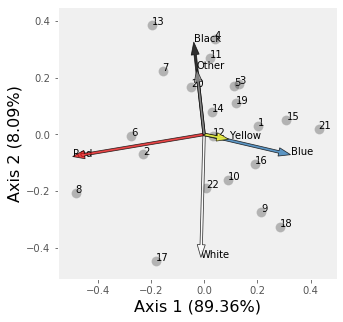

In [7]:
from plotting_helper import apca, draw_painting_biplot

# Perform Aitchison PCA
ordination = apca(table.astype(float))

# Style and draw the biplot, using the first and second principal components
# https://github.com/jupyter/notebook/issues/3523#issuecomment-534379015
%matplotlib inline
draw_painting_biplot(ordination, "Axis 1", "Axis 2")

### 2.1. Viewing the loadings from the biplot
When we used Aitchison PCA above, we got a scikit-bio [OrdinationResults](http://scikit-bio.org/docs/latest/generated/skbio.stats.ordination.OrdinationResults.html) object. This contains the sample and feature loadings underlying the biplot that was generated, as well as some additional information. (If you're interested in more details, we encourage you to check out the `plotting_helper.py` code provided in this folder.)

#### 2.1.1. Feature Loadings

In [8]:
ordination.features.head()

,Axis 1,Axis 2,Axis 3,Axis 4,Axis 5,Axis 6
FeatureID,,,,,,
Black,-0.064761,0.544208,-0.613059,0.089231,-0.029922,0.561200
White,-0.020050,-0.724314,-0.076465,0.250907,0.242065,0.589551
Blue,0.541021,-0.119259,-0.406345,0.603313,-0.163494,-0.370459
Red,-0.822854,-0.130236,-0.312456,0.286674,0.010890,-0.354994
Yellow,0.153330,-0.028251,-0.372827,-0.338338,0.807347,-0.265347


#### 2.1.2. Sample Loadings

In [9]:
ordination.samples.head()

,Axis 1,Axis 2,Axis 3,Axis 4,Axis 5,Axis 6
SampleID,,,,,,
1,0.201856,0.030162,-0.287573,0.064628,0.159943,-0.223891
2,-0.229034,-0.070389,-0.124102,0.006208,0.367294,-0.248358
3,0.132704,0.178636,0.190798,-0.177530,-0.195614,-0.320854
4,0.040543,0.337643,0.071238,0.041441,-0.286849,-0.079429
5,0.112686,0.172617,-0.005097,0.187846,0.049491,-0.038578


### 2.2. Export the ordination information to a file
This will enable us to use the feature loadings contained in this file as feature rankings in Qurro.

In [10]:
ordination.write("output/apca-ordination.txt")

'output/apca-ordination.txt'

### 2.3. Optional: merge the sample loadings into the sample metadata
As we mentioned before, we don't really have a lot of information about these paintings. One thing we do have now, though, are loadings in the biplot for each sample. You can imagine visualizing these loadings in relation to a selected log-ratio—for example, as shown in the bottom four sub-figures of Fig. 5 in [Martino et al. 2019](https://msystems.asm.org/content/msys/4/1/e00016-19).

Here we're going to merge these loadings with our previous metadata to generate an augmented metadata file, and we'll use that augmented metadata file in Qurro.

In [11]:
merged_metadata = metadata.merge(
    ordination.samples,
    how="left",
    left_index=True,
    right_index=True,
    suffixes=(False, False)
)
merged_metadata.to_csv("output/merged-metadata.tsv", sep="\t")
merged_metadata.head()

,proportion_black,proportion_white,proportion_blue,proportion_red,proportion_yellow,proportion_other,data_source,Axis 1,Axis 2,Axis 3,Axis 4,Axis 5,Axis 6
SampleID,,,,,,,,,,,,,
1,0.125,0.243,0.153,0.031,0.181,0.266,AitchisonGreenacre2002,0.201856,0.030162,-0.287573,0.064628,0.159943,-0.223891
2,0.143,0.224,0.111,0.051,0.159,0.313,AitchisonGreenacre2002,-0.229034,-0.070389,-0.124102,0.006208,0.367294,-0.248358
3,0.147,0.231,0.058,0.129,0.133,0.303,AitchisonGreenacre2002,0.132704,0.178636,0.190798,-0.177530,-0.195614,-0.320854
4,0.164,0.209,0.120,0.047,0.178,0.282,AitchisonGreenacre2002,0.040543,0.337643,0.071238,0.041441,-0.286849,-0.079429
5,0.197,0.151,0.132,0.033,0.188,0.299,AitchisonGreenacre2002,0.112686,0.172617,-0.005097,0.187846,0.049491,-0.038578


## 3. Run Qurro

Our inputs will be the following three files:

  - **Feature table:** The BIOM table we generated in section 1.1.3 above.
  
  
  - **Sample metadata:** The merged metadata file we generated in section 2.3 above.
  
  
  - **Feature rankings:** The feature loadings we exported in section 2.2 above.

In [12]:
!qurro --help

Usage: qurro [OPTIONS]

  Generates a visualization of feature rankings and log-ratios.

  The resulting visualization contains two plots. The first plot shows how
  features are ranked, and the second plot shows the log-ratio of "selected"
  features' abundances within samples.

  The visualization is interactive, so which features are "selected" to
  construct log-ratios -- as well as various other properties of the
  visualization -- can be changed by the user.

Options:
  -r, --ranks TEXT                Either feature differentials or an
                                  ordination containing feature loadings. When
                                  sorted numerically, these provide feature
                                  rankings.  [required]
  -t, --table TEXT                A BIOM table describing the abundances of
                                  the ranked features in samples. Note that
                                  empty samples and features will be removed
            

In [13]:
!qurro \
    --table output/color-table.biom \
    --sample-metadata output/merged-metadata.tsv \
    --ranks output/apca-ordination.txt \
    --output-dir output/qurro-viz/

/Users/mfedarko/Dropbox/Work/KnightLab/qurro/qurro/_df_utils.py:126: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  table_sdf = pd.SparseDataFrame(table.matrix_data, default_fill_value=0.0)
/Users/mfedarko/anaconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/mfedarko/anaconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Serie